# ML Classifier Copies - Room Occupancy Detection Model Example

An example where we take an existing "black box" classifier model of the publicly available [Room Occupancy Detection dataset](https://archive-beta.ics.uci.edu/ml/datasets/occupancy+detection), that we can query in order to obtain a copy.

Since we don't know the orginal model family, we will build several copies from different model families and compare the copy fidelity and performance.

(NOTE: Since we **did** build this model, we do have in fact all information.)

<a name="Index">
    
----
# Table of contents

    
1. [**Load original model**](#Original)
2. [**Build copies**](#Copies)
3. [**Evaluate copies**](#Evaluation)
----

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from presc.dataset import Dataset
from presc.copies.copying import ClassifierCopy
from presc.copies.evaluations import multivariable_density_comparison
from presc.copies.sampling import grid_sampling, uniform_sampling, normal_sampling, spherical_balancer_sampling, labeling

from ML_copies_original_models import WinesModel, OccupancyModel, SegmentationModel

[Index](#Index)  
  
  


<a name="Original">  

-----
-----
# Load original model

In [6]:
occupancy_model = OccupancyModel()

[Index](#Index)  
  
  


<a name="Copies">  

-----
# Build copies

In [7]:
log_normal_classifier = Pipeline([('scaler', StandardScaler()), ('log_classifier', 
                                   LogisticRegression())])
knn_normal_classifier = Pipeline([('scaler', StandardScaler()), ('KKN_classifier', 
                                KNeighborsClassifier(n_neighbors=30, weights="distance"))])
svm_normal_classifier = Pipeline([('scaler', StandardScaler()), ('SVC_classifier', SVC(kernel="linear"))])

We will assume that we don't know anything about the distribution of the numerical features, but that we can normalize them as a pre-processing step before training the model and thus force them to be centered at 0 and have a standard deviation of 1.

In [8]:
feature_description = occupancy_model.feature_description

In [9]:
balance_parameters={"max_iter": 50, "nbatch": 1500, "verbose": False}
log_normal_copy = ClassifierCopy(occupancy_model.model, log_normal_classifier, normal_sampling,
                                 enforce_balance=False, nsamples=2000, random_state=42,
                                 feature_parameters=feature_description, label_col="Occupancy",
                                 **balance_parameters)
log_normal_copy_training_data = log_normal_copy.copy_classifier(get_training_data=True)

knn_normal_copy = ClassifierCopy(occupancy_model.model, knn_normal_classifier, normal_sampling,
                                  enforce_balance=False, nsamples=2000, random_state=42,
                                  feature_parameters=feature_description, label_col="Occupancy",
                                  **balance_parameters) 
knn_normal_copy_training_data = knn_normal_copy.copy_classifier(get_training_data=True)

svm_normal_copy = ClassifierCopy(occupancy_model.model, svm_normal_classifier, normal_sampling,
                                 enforce_balance=False, nsamples=2000, random_state=42,
                                 feature_parameters=feature_description, label_col="Occupancy",
                                 **balance_parameters) 
svm_normal_copy_training_data = svm_normal_copy.copy_classifier(get_training_data=True)

[Index](#Index)  
  
  


<a name="Evaluation">  

-----
# Evaluate copies
    
### Evaluation summary

In [10]:
print("\n * Logistic regression copy:")
synthetic_log_normal_test_data = log_normal_copy.generate_synthetic_data(nsamples=2000, random_state=43)
evaluation_log_normal_copy = log_normal_copy.evaluation_summary(test_data=Dataset(
                                                occupancy_model.X_test.join(occupancy_model.y_test), label_col="Occupancy"), 
                                                                  synthetic_data=synthetic_log_normal_test_data)

print("\n * KNN copy:")
synthetic_knn_normal_test_data = knn_normal_copy.generate_synthetic_data(nsamples=2000, random_state=43)
evaluation_knn_normal_copy = knn_normal_copy.evaluation_summary(test_data=Dataset(
                                                occupancy_model.X_test.join(occupancy_model.y_test), label_col="Occupancy"), 
                                                                  synthetic_data=synthetic_knn_normal_test_data)

print("\n * Linear SVM copy:")
synthetic_svm_normal_test_data = svm_normal_copy.generate_synthetic_data(nsamples=2000, random_state=43)
evaluation_svm_normal_copy = svm_normal_copy.evaluation_summary(test_data=Dataset(
                                                occupancy_model.X_test.join(occupancy_model.y_test), label_col="Occupancy"), 
                                                                  synthetic_data=synthetic_svm_normal_test_data)


 * Logistic regression copy:
Original Model Accuracy (test)          0.9914
Copy Model Accuracy (test)              0.9898
Empirical Fidelity Error (synthetic)    0.0935
Empirical Fidelity Error (test)         0.0131
Replacement Capability (synthetic)      0.9065
Replacement Capability (test)           0.9983

 * KNN copy:
Original Model Accuracy (test)          0.9914
Copy Model Accuracy (test)              0.9652
Empirical Fidelity Error (synthetic)    0.0860
Empirical Fidelity Error (test)         0.0377
Replacement Capability (synthetic)      0.9140
Replacement Capability (test)           0.9736

 * Linear SVM copy:
Original Model Accuracy (test)          0.9914
Copy Model Accuracy (test)              0.9844
Empirical Fidelity Error (synthetic)    0.0695
Empirical Fidelity Error (test)         0.0180
Replacement Capability (synthetic)      0.9305
Replacement Capability (test)           0.9930


[Index](#Index)  
  
  


<a name="Densities">  


### Summary of class density projections for each classifier

The data points for the visualization of the original classifier and copies topologies must be sampled homogeneously throughout the feature space to avoid introducing spurious shapes in the projected density distributions. **uniform_sampling** is a good option for that. 

**grid_sampling** is not recommended because it samples the specific interval points and displays density peaks.

In [11]:
# Class colors
colors = {0:"red", 1:"royalblue"}

In [12]:
visualization_data = uniform_sampling(nsamples=1000, feature_parameters=feature_description)

visualization_original = labeling(visualization_data, occupancy_model.model, label_col="Occupancy")
visualization_log = labeling(visualization_data, log_normal_copy.copy, label_col="Occupancy")
visualization_knn = labeling(visualization_data, knn_normal_copy.copy, label_col="Occupancy")
visualization_svm = labeling(visualization_data, svm_normal_copy.copy, label_col="Occupancy")

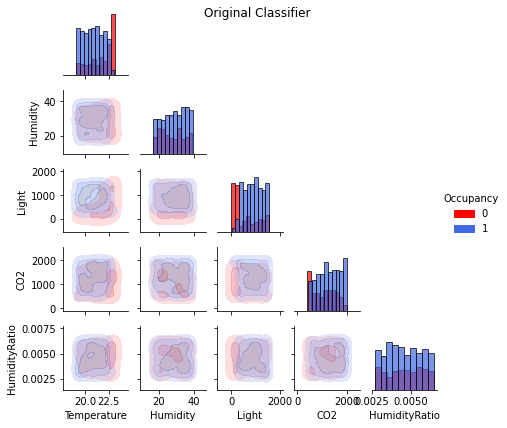

In [13]:
g = sns.PairGrid(visualization_original.df, hue="Occupancy", palette=colors, corner=True, height=1.2,
                 vars=[var_name for var_name in visualization_original.feature_names[:]])
g = g.map_diag(plt.hist, edgecolor="k", alpha=0.7)
g = g.map_lower(sns.kdeplot, alpha=0.3, shade=True, n_levels=4)
g = g.add_legend()
g = g.fig.suptitle('Original Classifier')
plt.show()

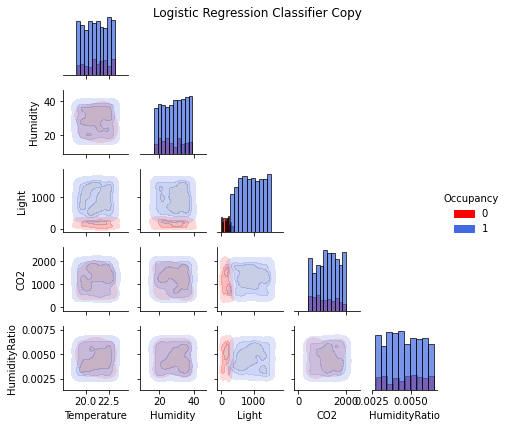

In [14]:
g = sns.PairGrid(visualization_log.df, hue="Occupancy", palette=colors, corner=True, height=1.2,
                 vars=[var_name for var_name in visualization_log.feature_names[:]])

g = g.map_diag(plt.hist, edgecolor="k", alpha=0.7)
g = g.map_lower(sns.kdeplot, alpha=0.3, shade=True, n_levels=4)
g = g.add_legend()
g = g.fig.suptitle('Logistic Regression Classifier Copy')
plt.show()

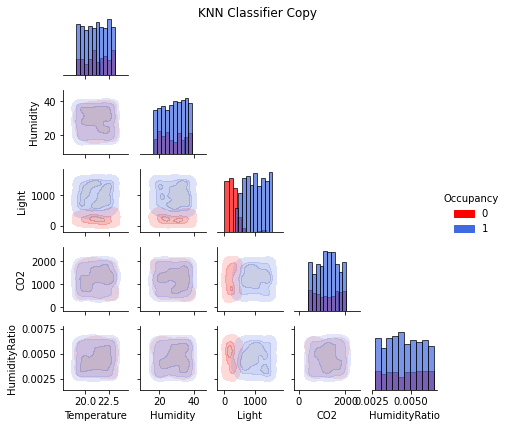

In [15]:
g = sns.PairGrid(visualization_knn.df, hue="Occupancy", palette=colors, corner=True, height=1.2,
                 vars=[var_name for var_name in visualization_knn.feature_names[:]])
g = g.map_diag(plt.hist, edgecolor="k", alpha=0.7)
g = g.map_lower(sns.kdeplot, alpha=0.3, shade=True, n_levels=4)
g = g.add_legend()
g = g.fig.suptitle('KNN Classifier Copy')
plt.show()

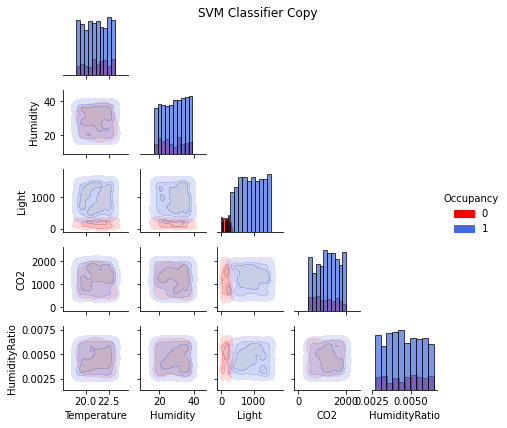

In [16]:
g = sns.PairGrid(visualization_svm.df, hue="Occupancy", palette=colors, corner=True, height=1.2,
                 vars=[var_name for var_name in visualization_svm.feature_names[:]])
g = g.map_diag(plt.hist, edgecolor="k", alpha=0.7)
g = g.map_lower(sns.kdeplot, alpha=0.3, shade=True, n_levels=4)
g = g.add_legend()
g = g.fig.suptitle('SVM Classifier Copy')
plt.show()

[Index](#Index)  
  
  


<a name="Densities">  


### Examples of detailed class density projections for each classifier

In [17]:
# Common parameters
titles = ["Original Classifier", "Logistic Regression Classifier Copy", "KNN Classifier Copy", "SVM Classifier Copy"]
datasets = [visualization_original.df, visualization_log.df, visualization_knn.df, visualization_svm.df]
other_kwargs = {"alpha":0.3, "common_norm":True, "palette": colors, "shade": True, "n_levels": 4,
                "legend": False}

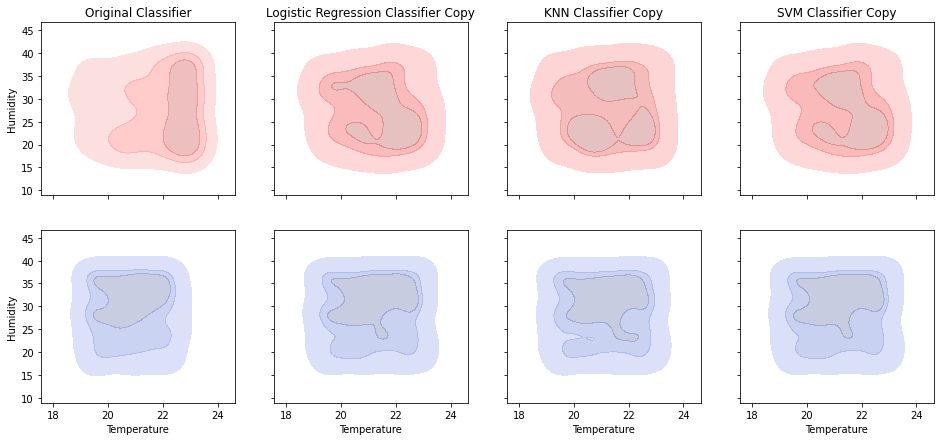

In [26]:
%%capture --no-display
feature1 = "Temperature"
feature2 = "Humidity"
fig, axs = multivariable_density_comparison(datasets=datasets, feature1=feature1, feature2=feature2, label_col="Occupancy",
                                            titles=titles, other_kwargs=other_kwargs)

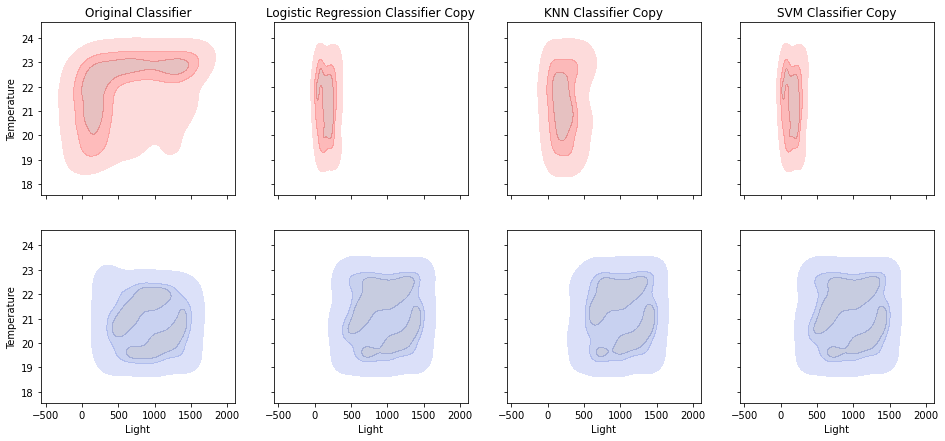

In [27]:
%%capture --no-display
feature1= "Light"
feature2= "Temperature"
fig, axs = multivariable_density_comparison(datasets=datasets, feature1=feature1, feature2=feature2, label_col="Occupancy",
                                            titles=titles, other_kwargs=other_kwargs)

[Index](#Index)  
  
  

-----
-----

----